# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob as gb
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import os

# Preparing data

In [2]:
data_training = '/kaggle/input/yawn-eye-dataset-new/dataset_new/train/'
data_test = '/kaggle/input/yawn-eye-dataset-new/dataset_new/test/'

In [3]:
for folder in  os.listdir(data_training): 
    files = gb.glob(pathname= str( data_training + folder + '/*.jpg'))
    print(f'For data , found {len(files)} in folder {folder}')

For data , found 617 in folder Closed
For data , found 617 in folder Open
For data , found 617 in folder yawn
For data , found 616 in folder no_yawn


In [4]:
code = {'Closed':0, 'Open':1}
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [5]:
size = []
for folder in os.listdir(data_training) :
    if folder == 'Closed' or folder == 'Open':
        files = gb.glob(pathname= str( data_training + folder + '/*.jpg'))
        for file in files: 
            image = plt.imread(file)
            size.append(image.shape)
    else:
        break
pd.Series(size).value_counts

<bound method IndexOpsMixin.value_counts of 0       (223, 223, 3)
1       (109, 110, 3)
2       (300, 266, 3)
3       (232, 273, 3)
4        (91, 115, 3)
            ...      
1229    (539, 529, 3)
1230    (321, 300, 3)
1231      (64, 74, 3)
1232    (427, 311, 3)
1233    (102, 113, 3)
Length: 1234, dtype: object>

In [6]:
s = 140
X_Train = []
y_Train = []
for folder in  os.listdir(data_training) : 
    if folder == 'Closed' or folder == 'Open':
        files = gb.glob(pathname= str( data_training + folder + '/*.jpg'))
        for file in files: 
            image = cv2.imread(file)
            image_array = cv2.resize(image , (s,s))
            X_Train.append(list(image_array))
            y_Train.append(code[folder])
    else:
        break

In [7]:
print(f'we have {len(X_Train)} items in X_Train')
print(f'we have {len(y_Train)} items in Y_Train')

we have 1234 items in X_Train
we have 1234 items in Y_Train


In [8]:
X_test = []
y_test = []
for folder in  os.listdir(data_test) : 
    if folder == 'Closed' or folder == 'Open':
        files = gb.glob(pathname= str( data_test + folder + '/*.jpg'))
        for file in files: 
            image = cv2.imread(file)
            image_array = cv2.resize(image , (s,s))
            X_test.append(list(image_array))
            y_test.append(code[folder])
    else:
        break

In [9]:
print(f'we have {len(X_test)} items in X_Test')
print(f'we have {len(y_test)} items in Y_Test')

we have 218 items in X_Test
we have 218 items in Y_Test


# Visualizing for some our data

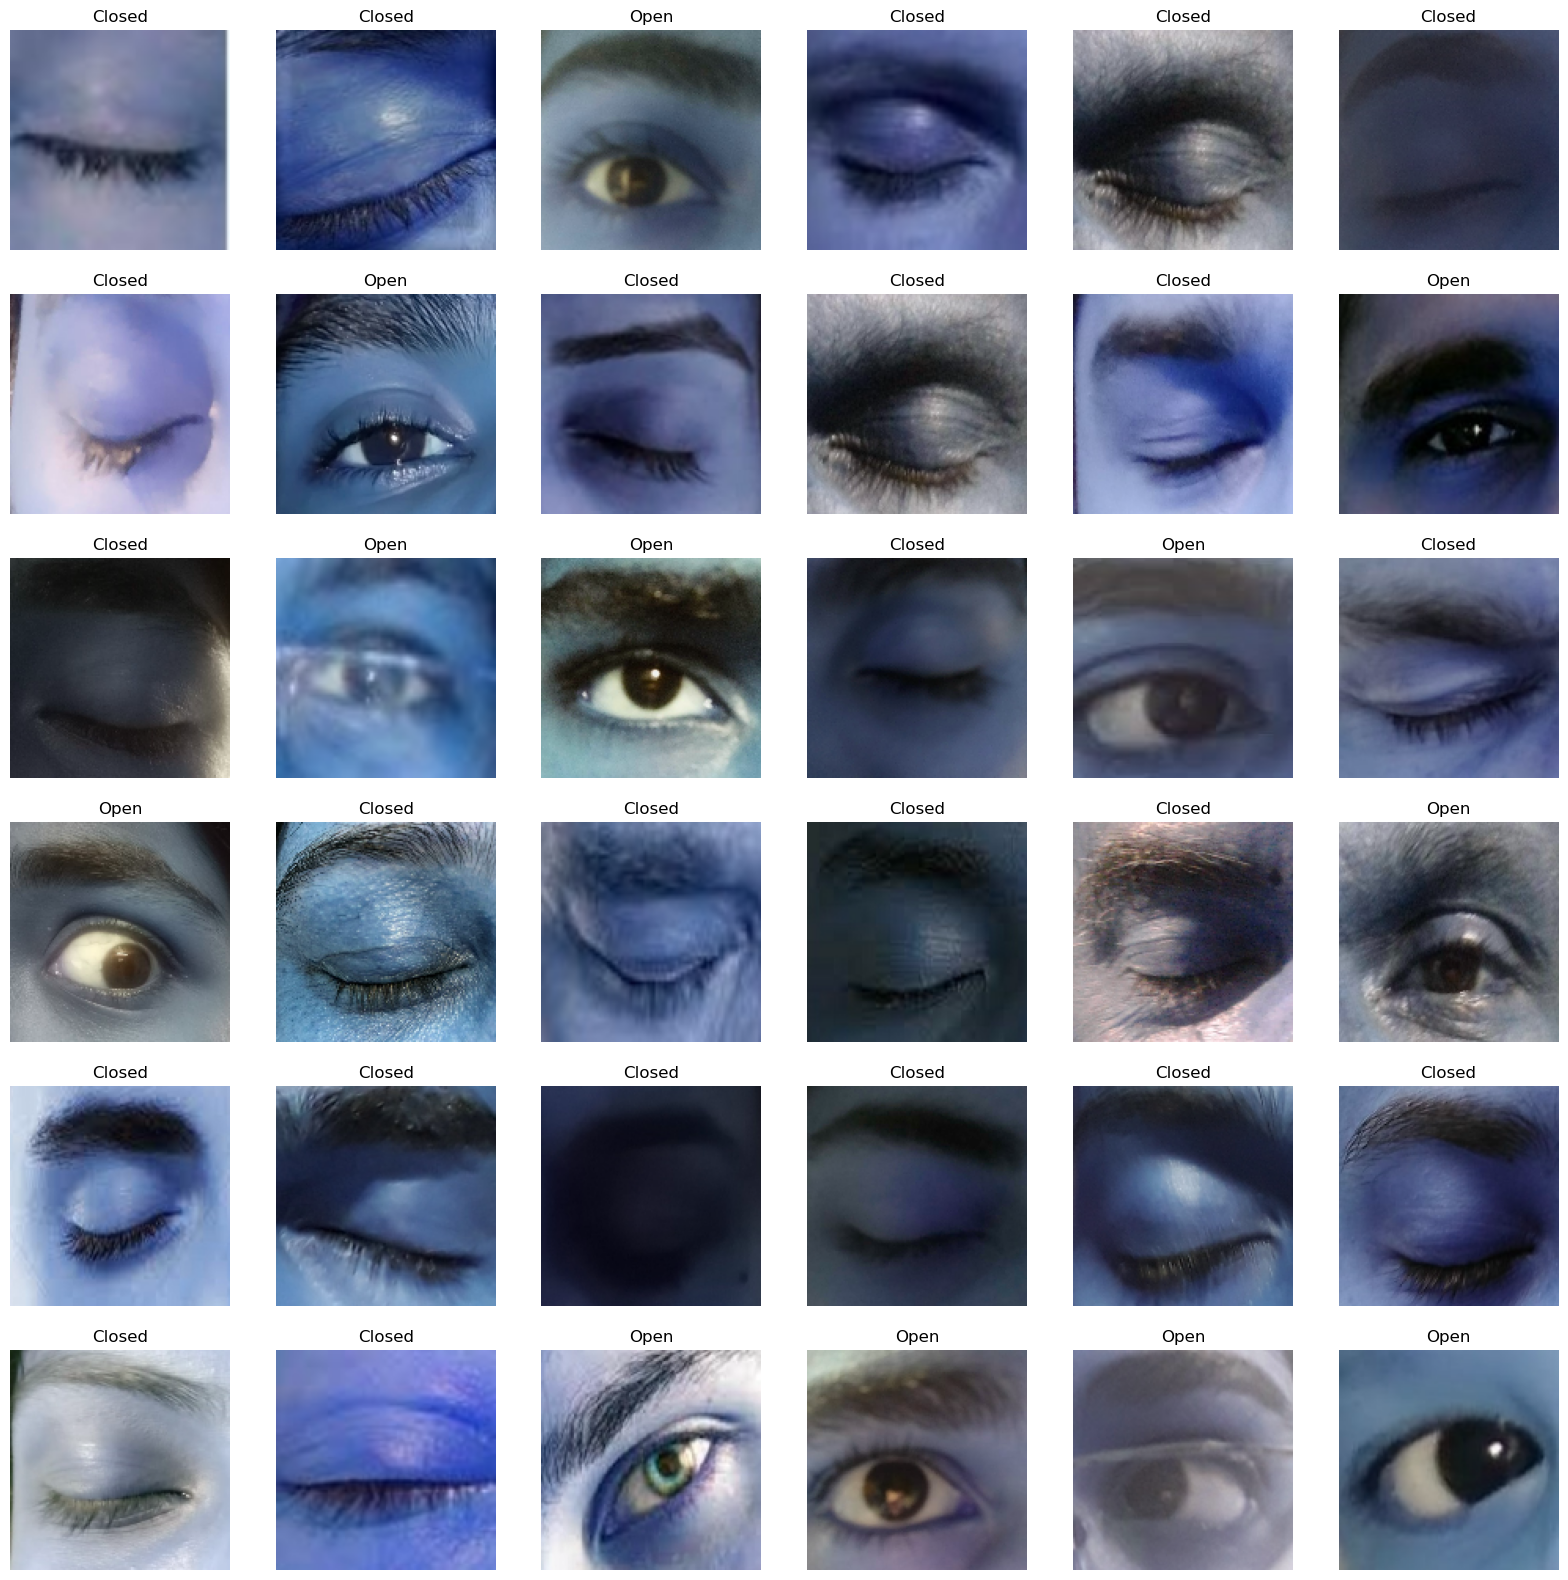

In [10]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_Train),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_Train[i])   
    plt.axis('off')
    plt.title(getcode(y_Train[i]))

# Splitting data for training and validation

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_Train, y_Train, train_size=0.8, shuffle=True, random_state=0)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

temp2 = list(zip(X_test, y_test))
random.shuffle(temp2)
X_test, y_test = zip(*temp2)
X_test, y_test = np.array(X_test), np.array(y_test)

# Building our Model

In [12]:
model = Sequential([
        Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(s,s,3)),
        Conv2D(32,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64,kernel_size=(5,5),activation='relu'),    
        Conv2D(64,kernel_size=(5,5),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128,kernel_size=(5,5),activation='relu'),
        Conv2D(128,kernel_size=(5,5),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(256,kernel_size=(3,3),activation='relu'),
        Conv2D(256,kernel_size=(3,3),activation='relu'),
        Flatten() ,    
        Dense(512,activation='relu') ,    
        Dense(512,activation='relu') ,
        Dense(256,activation='relu') ,
        Dense(256,activation='relu') ,
        Dense(128,activation='relu') ,
        Dense(1,activation='sigmoid') ,    
        ])

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00008)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 138, 138, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 136, 136, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 68, 68, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                    

#### Using image generator for increasing our data

In [15]:
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=10, zoom_range=0.2, 
                             brightness_range=(0.1, 0.8))

##### Training model

In [16]:
epochs = 20
ThisModel = model.fit_generator(datagen.flow(X_train,y_train, batch_size=32), epochs=epochs,
                                     validation_data=(X_val,y_val), validation_steps=1, verbose=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
31/31 [==============================] - 24s 317ms/step - loss: 0.4390 - accuracy: 0.8247 - val_loss: 0.3897 - val_accuracy: 0.9150
Epoch 2/20
31/31 [==============================] - 6s 189ms/step - loss: 0.1917 - accuracy: 0.9412 - val_loss: 0.2715 - val_accuracy: 0.9352
Epoch 3/20
31/31 [==============================] - 6s 179ms/step - loss: 0.2030 - accuracy: 0.9372 - val_loss: 0.1475 - val_accuracy: 0.9595
Epoch 4/20
31/31 [==============================] - 5s 169ms/step - loss: 0.1112 - accuracy: 0.9635 - val_loss: 0.2348 - val_accuracy: 0.9474
Epoch 5/20
31/31 [==============================] - 6s 178ms/step - loss: 0.1767 - accuracy: 0.9402 - val_loss: 0.2014 - val_accuracy: 0.9433
Epoch 6/20
31/31 [==============================] - 6s 177ms/step - loss: 0.1200 - accuracy: 0.9676 - val_loss: 0.0813 - val_accuracy: 0.9676
Epoch 7/20
31/31 [==============================] - 6s 178ms/step - loss: 0.0970 - accuracy: 0.9686 - val_loss: 0.1819 - val_accuracy: 0.9555
Epoch

##### Evaluate model

In [17]:
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test,batch_size=32)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

7/7 [==============================] - 1s 121ms/step - loss: 0.1907 - accuracy: 0.9771
Test Loss is 0.19068536162376404
Test Accuracy is 0.9770641922950745


#### summarize model for accuracy and loss

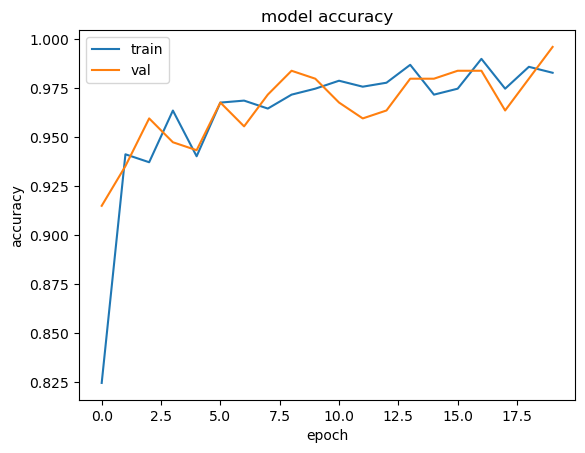

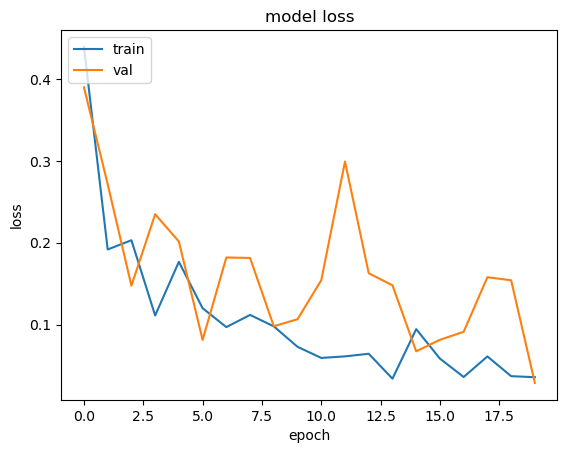

In [18]:
# summarize model for accuracy
plt.plot(ThisModel.history['accuracy'])
plt.plot(ThisModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize model for loss
plt.plot(ThisModel.history['loss'])
plt.plot(ThisModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Predict testing data

In [19]:
y_pred = model.predict(X_test)
pred = [1 * (x[0]>=0.5) for x in y_pred]
print('Prediction Shape is {}'.format(y_pred.shape))

7/7 [==============================] - 0s 12ms/step
Prediction Shape is (218, 1)


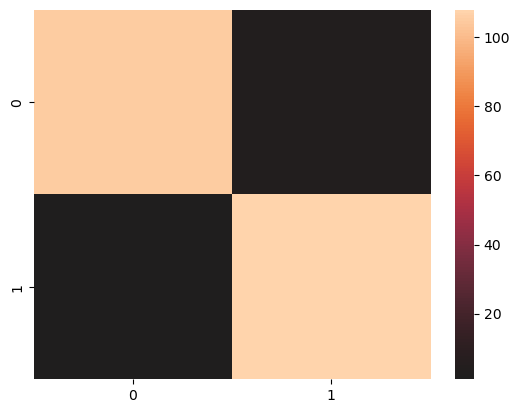

Confusion Matrix is
 [[105   4]
 [  1 108]]


In [20]:
CM = confusion_matrix(y_test, pred)

sns.heatmap(CM, center=True)
plt.show()

print('Confusion Matrix is\n', CM)


In [21]:
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       109
           1       0.96      0.99      0.98       109

    accuracy                           0.98       218
   macro avg       0.98      0.98      0.98       218
weighted avg       0.98      0.98      0.98       218

0.9770642201834863


#### Visualizing for some testing data

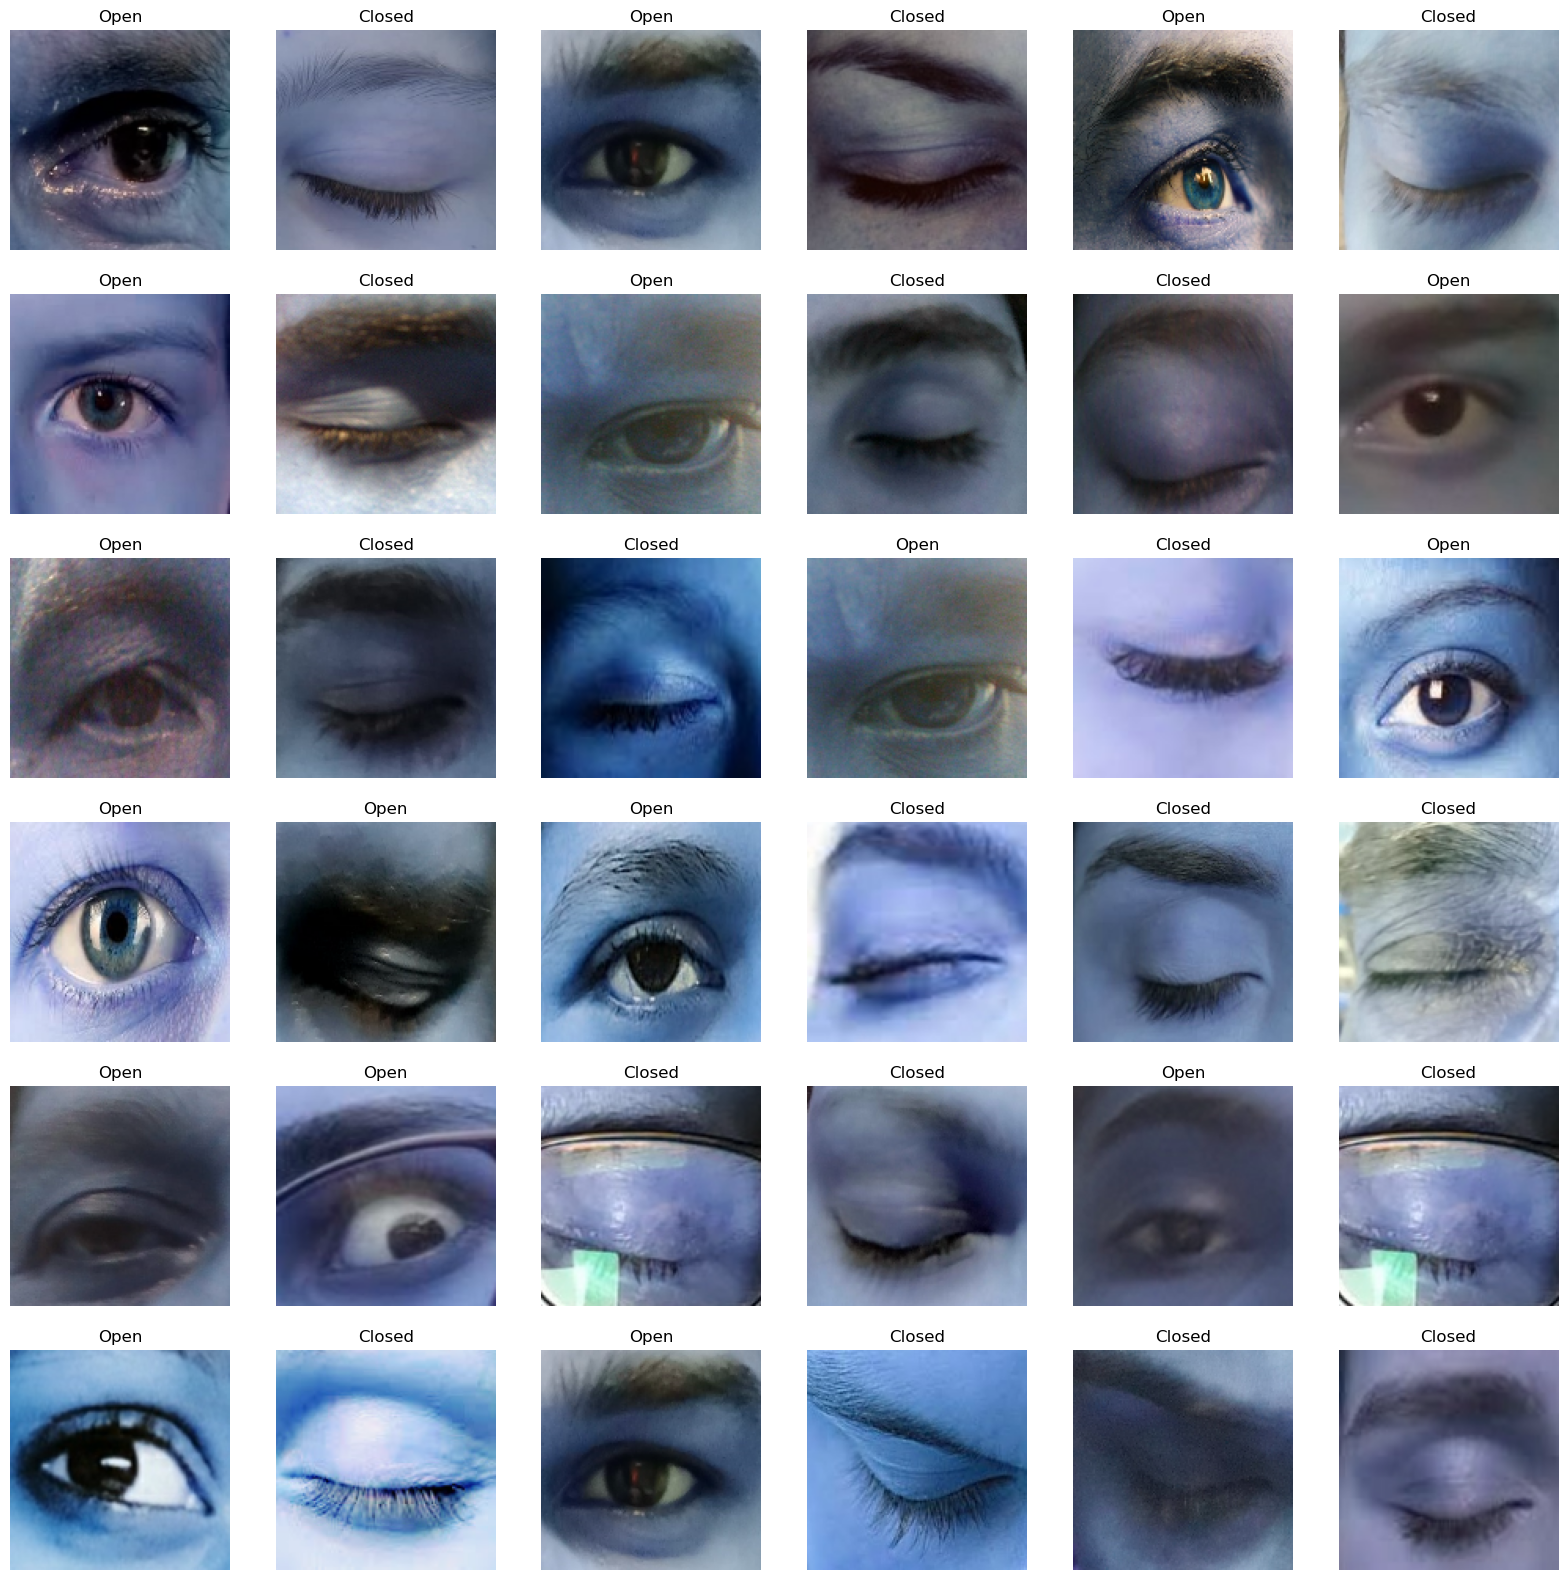

In [22]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_test),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_test[i])    
    plt.axis('off')
    plt.title(getcode(pred[i]))

#### Saving our model

In [23]:
model.save('driver_state.h5')